In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
import math

<Strong> Grabbing the data from stored files (originally pulled from Binance) </Strong>

In [5]:
#df_btc = pd.read_csv("../../cryptoData/BTC_1h_data.csv")
df_btc = pd.read_csv("BTC_1h_data.csv")

<Strong> Grabbing the closing price (univariate) </Strong>

In [6]:
# Removing everything but the closing price
btc_data = df_btc.values[:, 4 ,].astype(float)

btc_data[-1]

43534.54

<Strong> Scaling the data  </Strong>

In [7]:
percTrain = 70
percVal = 20 

In [8]:
scaler = MinMaxScaler()
    
onePercent = len(btc_data) // 100
numberTraining = onePercent * percTrain

reshaped_data = btc_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_btc = scaler.transform(reshaped_data)

<Strong> Creating Matrix in Sliding window form <Strong>

In [9]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

In [10]:
# Using 24 datapoints to predict the 25th

window_length = 120
features = 1

sliding_winda_btc = sliding_window(scaled_btc , window_length)

<Strong> Splitting the data after we create Sliding Window matrix (more data) </Strong>

In [11]:
# Splitting the data after creating the sliding window data
def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

In [12]:
#Reshaping the data so we can use min-max a
btc_train , btc_val , btc_test = splitting_train_test(sliding_winda_btc)

print(btc_train[0].shape)

(27370, 120, 1)


<Strong> Creating a function to create the model. </Strong>

<p> Keras Tuner for hyper-param tuning </p>

In [13]:
# Hyperparameters 

# Dense layer neurons
# Learning rate 
# Dropout 
# Batch Size

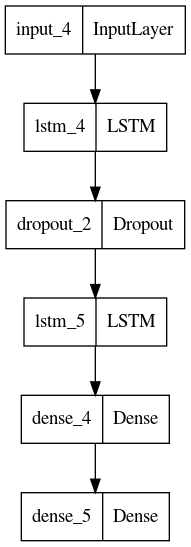

In [17]:


inputs = Input(shape = (window_length , features) )


x = LSTM(50 , return_sequences = True)(inputs)
x = Dropout(0.05)(x)
x = LSTM(50)(x)
x = Dense(units = 24 ,activation='relu')(x)
x = Dense(units = 1)(x) 

model = tf.keras.Model(inputs=inputs, outputs= x)
plot_model(model)



In [198]:
tuner = RandomSearch (
    build,
    objective = "val_loss",
    max_trials=50,
    executions_per_trial=1,
    directory = 'LSTM96',
    project_name='tuner'
)

In [199]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
dense units_1 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
learning_rate (Choice)
{'default': 0.005, 'conditions': [], 'values': [0.005, 0.001], 'ordered': True}
lstm_size (Choice)
{'default': 10, 'conditions': [], 'values': [10, 30, 50, 70], 'ordered': True}
2lstm_size (Choice)
{'default': 10, 'conditions': [], 'values': [10, 30, 50, 70], 'ordered': True}
dropout (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.05, 0.01], 'ordered': True}


In [200]:
tuner.search(btc_train[0] , btc_train[1] , epochs=500 , validation_data=btc_val , batch_size = 512 ,  callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=30)])


Trial 50 Complete [00h 05m 17s]
val_loss: 0.01248878799378872

Best val_loss So Far: 0.0006582255009561777
Total elapsed time: 01h 52m 31s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.get_best_hyperparameters()[0].values

In [ ]:
tuner.results_summary()